In [1]:
from utils import create_combined_embeddings, calc_ann_metric, display_random_item
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import cv2 as cv2
from tqdm.notebook import tqdm
import torch
from models import get_model2
from torchvision import transforms
from annoy import AnnoyIndex

In [2]:
company_data = pd.read_csv("company_data.csv")
comparable_data = pd.read_csv("comparable_data.csv")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
text_model_name = "Shakhovak/tiny_sent_transformer"
text_model = AutoModel.from_pretrained(text_model_name)
tokenizer = AutoTokenizer.from_pretrained(text_model_name)
text_model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(83828, 312, padding_idx=0)
    (position_embeddings): Embedding(2048, 312)
    (token_type_embeddings): Embedding(2, 312)
    (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-2): 3 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=312, out_features=312, bias=True)
            (key): Linear(in_features=312, out_features=312, bias=True)
            (value): Linear(in_features=312, out_features=312, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=312, out_features=312, bias=True)
            (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)

In [5]:
default_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

In [6]:
img_model = get_model2()
img_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
company_combined_emb = create_combined_embeddings('company_data.csv', img_model,
                                                  default_transform, text_model, tokenizer,
                                                  device)

  0%|          | 0/984 [00:00<?, ?it/s]

c:\Users\Kate\Desktop\cv_project\.venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [8]:
database_combined_emb = create_combined_embeddings(
    "comparable_data.csv", img_model, default_transform, text_model, tokenizer, device
)

  0%|          | 0/13718 [00:00<?, ?it/s]

In [9]:
forest = AnnoyIndex(len(database_combined_emb[0]), metric="angular")
for i, item in tqdm(enumerate(database_combined_emb)):
    forest.add_item(i, [x[0] for x in item.cpu().detach().tolist()])
forest_labels = comparable_data["target"].tolist()
forest.build(50)
forest.save("forest_combined_not_trainedv1.ann")

0it [00:00, ?it/s]

True

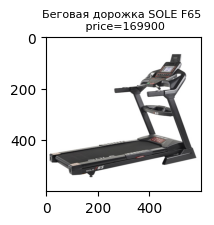

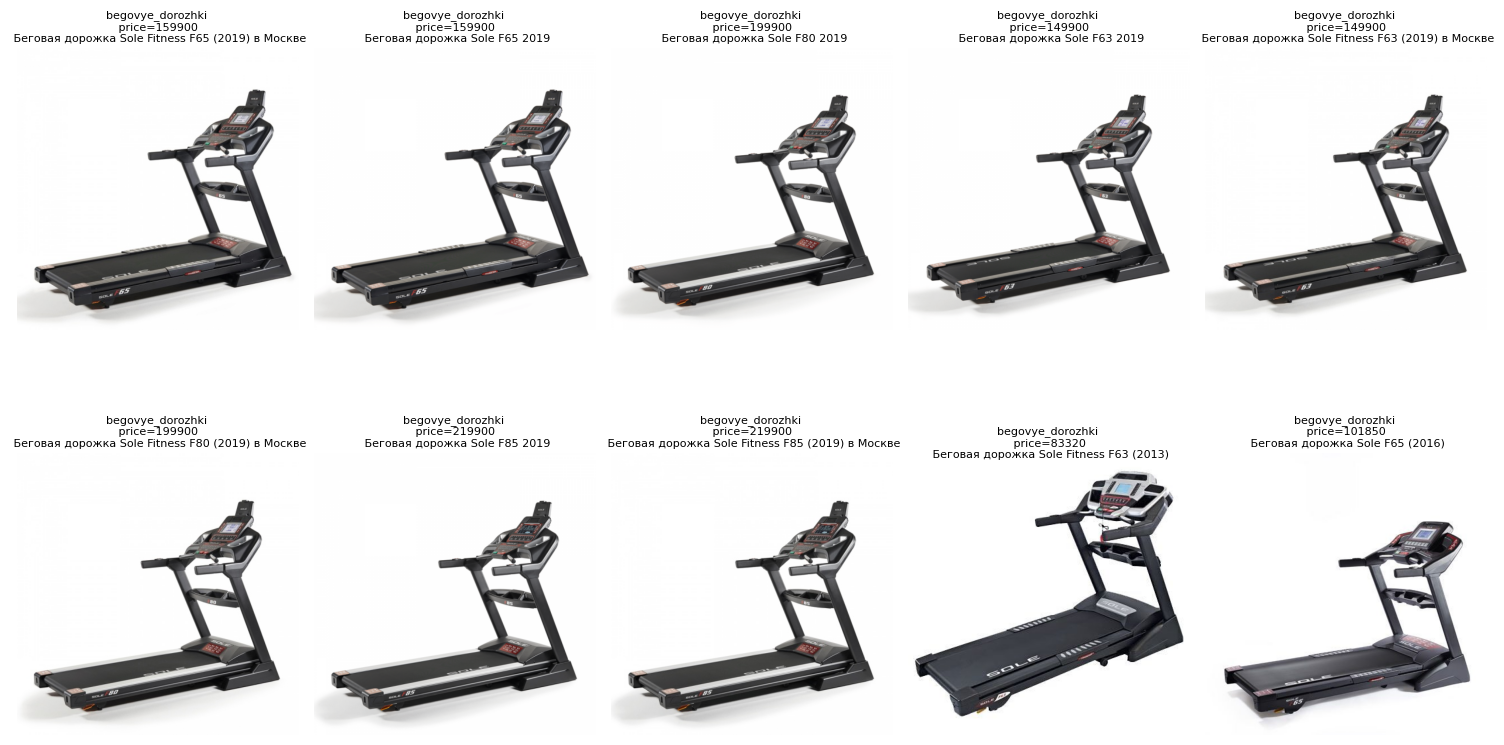

In [10]:
display_random_item(
    k=10,
    k_img=40,
    k_text=10,
    random_idx=0,
    method="ann_combined",
    company_data=company_data,
    company_emb=company_combined_emb,
    database_emb=database_combined_emb,
    comparable_data=comparable_data,
    forest=forest,
    text_model=text_model,
    tokenizer=tokenizer,
)

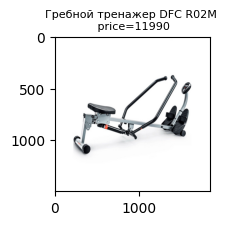

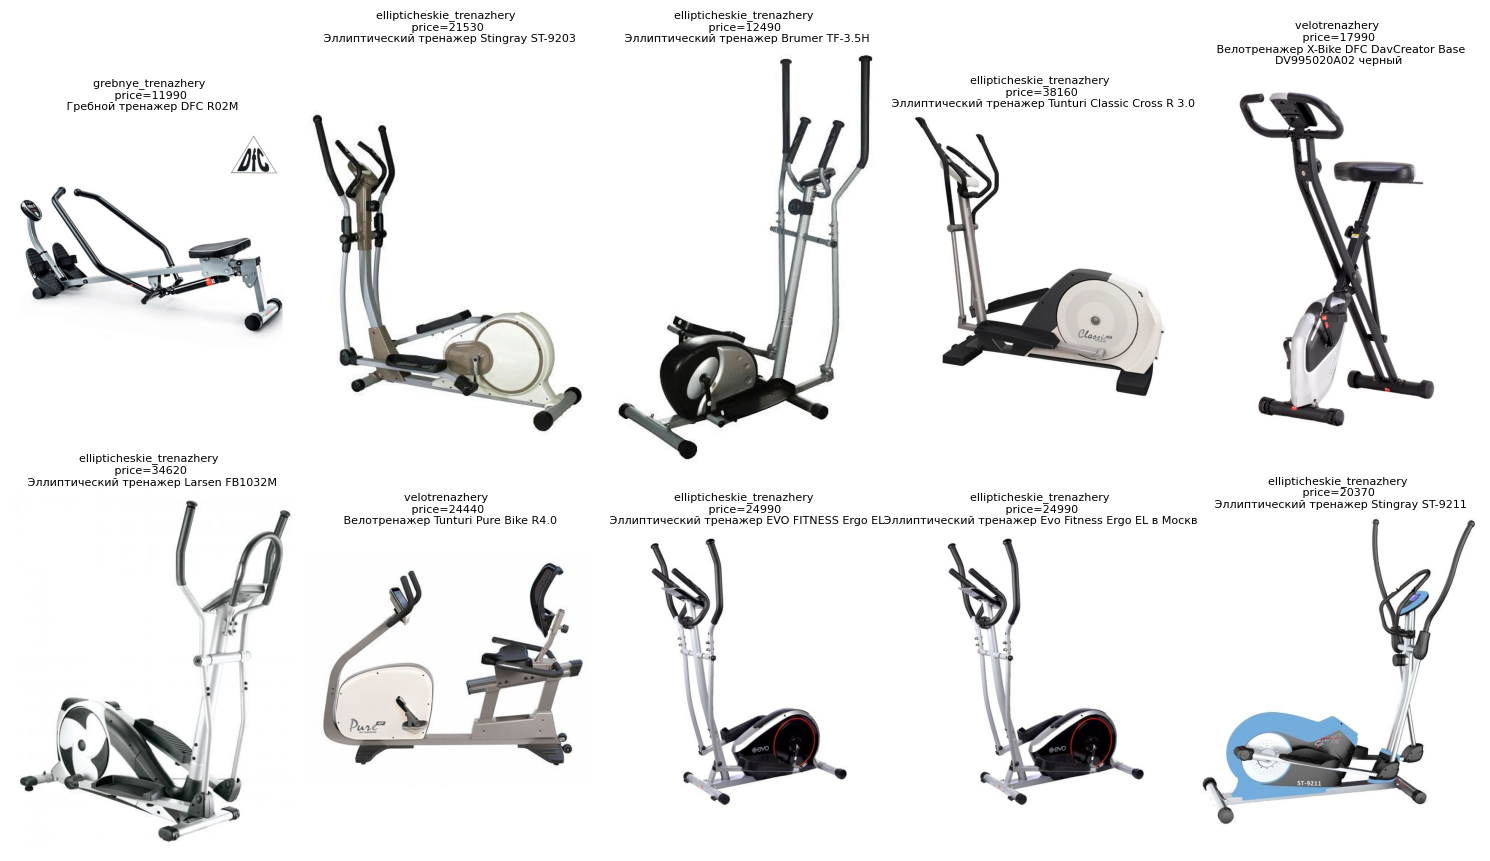

In [11]:
display_random_item(
    k=10,
    k_img=40,
    k_text=10,
    random_idx=500,
    method="ann_combined",
    company_data=company_data,
    company_emb=company_combined_emb,
    database_emb=database_combined_emb,
    comparable_data=comparable_data,
    forest=forest,
    text_model=text_model,
    tokenizer=tokenizer,
)

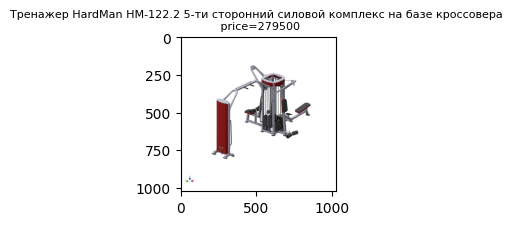

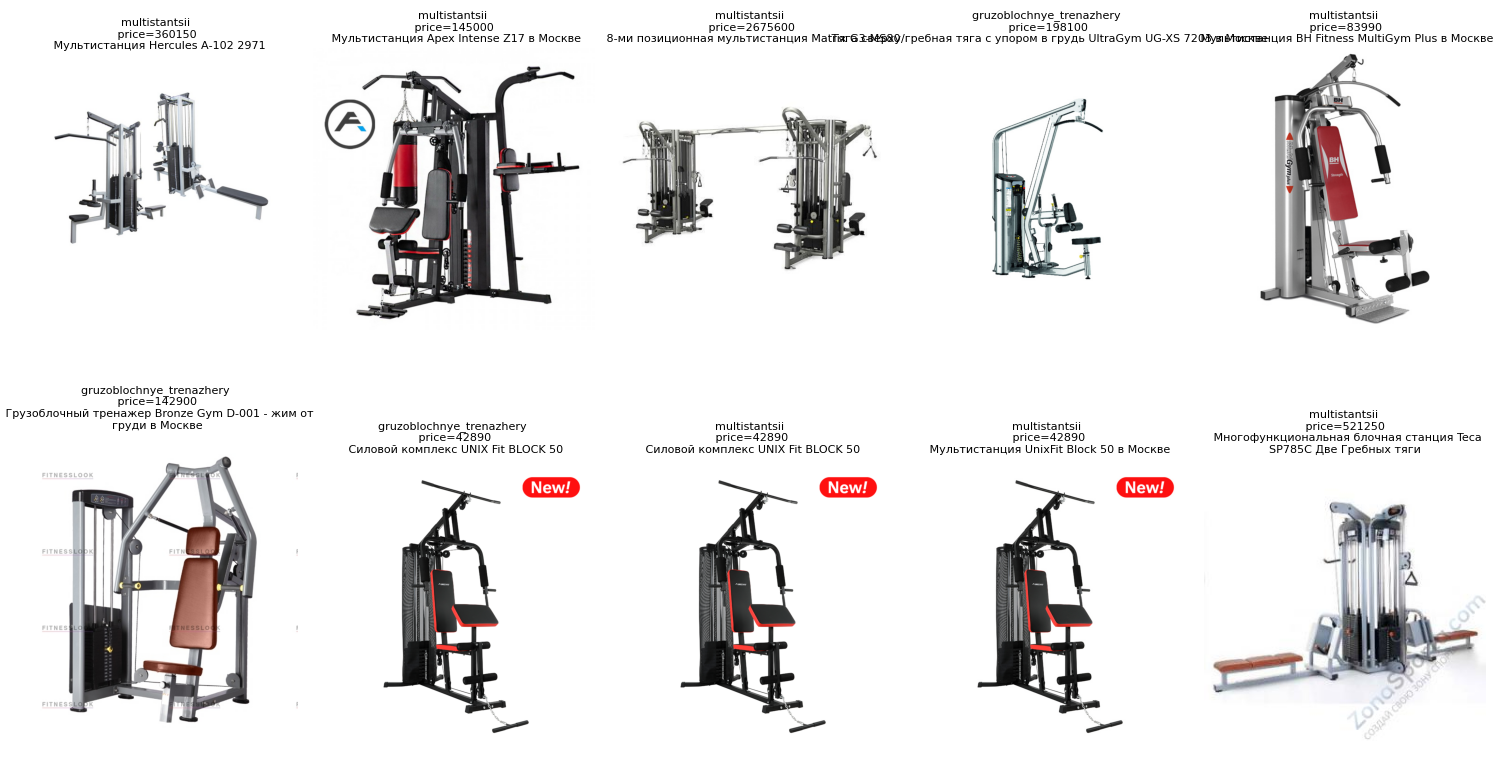

In [12]:
display_random_item(
    k=10,
    k_img=40,
    k_text=10,
    random_idx=621,
    method="ann_combined",
    company_data=company_data,
    company_emb=company_combined_emb,
    database_emb=database_combined_emb,
    comparable_data=comparable_data,
    forest=forest,
    text_model=text_model,
    tokenizer=tokenizer,
)

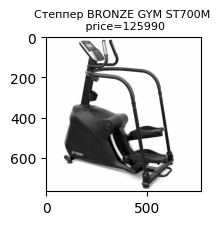

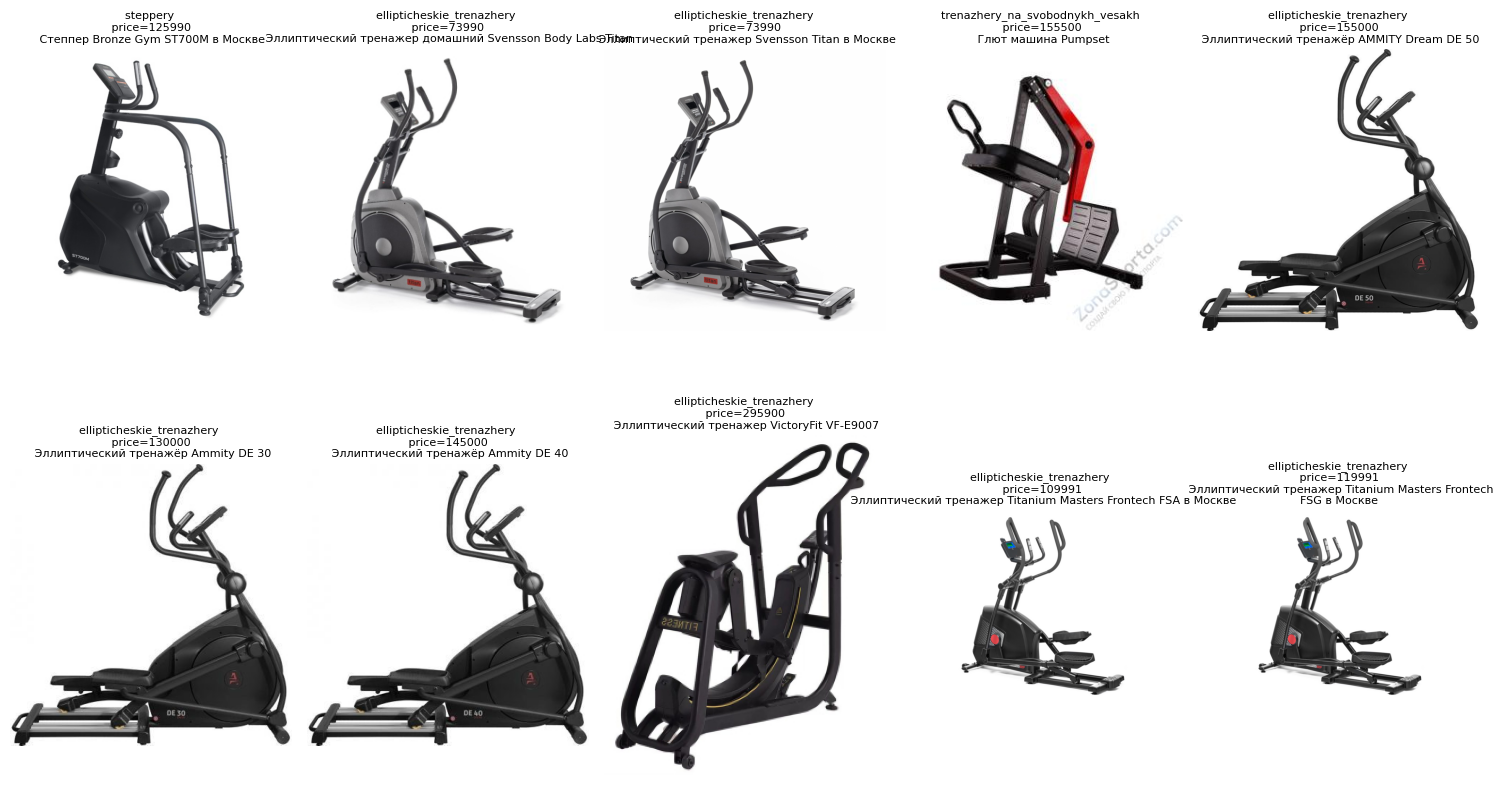

In [13]:
display_random_item(
    k=10,
    k_img=40,
    k_text=10,
    random_idx=626,
    method="ann_combined",
    company_data=company_data,
    company_emb=company_combined_emb,
    database_emb=database_combined_emb,
    comparable_data=comparable_data,
    forest=forest,
    text_model=text_model,
    tokenizer=tokenizer,
)

In [14]:
calc_ann_metric(10, forest, company_combined_emb, company_data, comparable_data, combined=True)
calc_ann_metric(5, forest, company_combined_emb, company_data, comparable_data, combined=True)

  0%|          | 0/984 [00:00<?, ?it/s]

multistantsii acc at 10: 0.6867
begovye_dorozhki acc at 10: 0.9931
ellipticheskie_trenazhery acc at 10: 0.954
steppery acc at 10: 0.3109
trenazhery_na_svobodnykh_vesakh acc at 10: 0.7048
grebnye_trenazhery acc at 10: 0.866
velotrenazhery acc at 10: 0.9792
Total acc at 10: 0.8519


  0%|          | 0/984 [00:00<?, ?it/s]

multistantsii acc at 5: 0.715
begovye_dorozhki acc at 5: 0.9954
ellipticheskie_trenazhery acc at 5: 0.9733
steppery acc at 5: 0.3709
trenazhery_na_svobodnykh_vesakh acc at 5: 0.7687
grebnye_trenazhery acc at 5: 0.936
velotrenazhery acc at 5: 0.9874
Total acc at 5: 0.8809


In [15]:
company_combined_emb_v2 = create_combined_embeddings(
    "company_data.csv",
    img_model,
    default_transform,
    text_model,
    tokenizer,
    device,
    info_used="title_cat",
)

  0%|          | 0/984 [00:00<?, ?it/s]

In [16]:
database_combined_emb_v2 = create_combined_embeddings(
    "comparable_data.csv",
    img_model,
    default_transform,
    text_model,
    tokenizer,
    device,
    info_used="title_cat",
)

  0%|          | 0/13718 [00:00<?, ?it/s]

In [17]:
forest = AnnoyIndex(len(database_combined_emb_v2[0]), metric="angular")
for i, item in tqdm(enumerate(database_combined_emb_v2)):
    forest.add_item(i, [x[0] for x in item.cpu().detach().tolist()])
forest_labels = comparable_data["target"].tolist()
forest.build(50)
forest.save("forest_combined_not_trainedv2.ann")

0it [00:00, ?it/s]

True

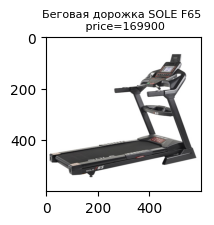

In [18]:
display_random_item(
    k=10,
    k_img=40,
    k_text=10,
    random_idx=0,
    method="ann_combined",
    company_data=company_data,
    company_emb=company_combined_emb_v2,
    database_emb=database_combined_emb_v2,
    comparable_data=comparable_data,
    forest=forest,
    text_model=None,
    tokenizer=None,
)

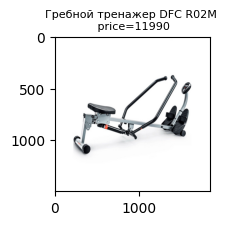

In [19]:
display_random_item(
    k=10,
    k_img=40,
    k_text=10,
    random_idx=500,
    method="ann_combined",
    company_data=company_data,
    company_emb=company_combined_emb_v2,
    database_emb=database_combined_emb_v2,
    comparable_data=comparable_data,
    forest=forest,
    text_model=None,
    tokenizer=None,
)

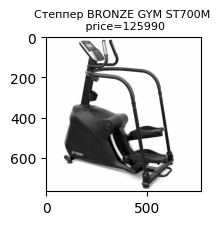

In [20]:
display_random_item(
    k=10,
    k_img=40,
    k_text=10,
    random_idx=626,
    method="ann_combined",
    company_data=company_data,
    company_emb=company_combined_emb_v2,
    database_emb=database_combined_emb_v2,
    comparable_data=comparable_data,
    forest=forest,
    text_model=None,
    tokenizer=None,
)

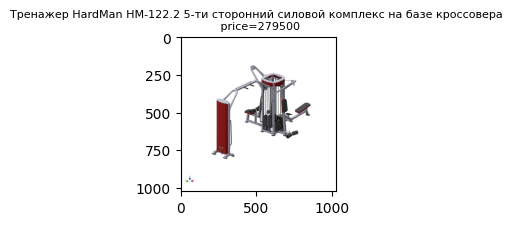

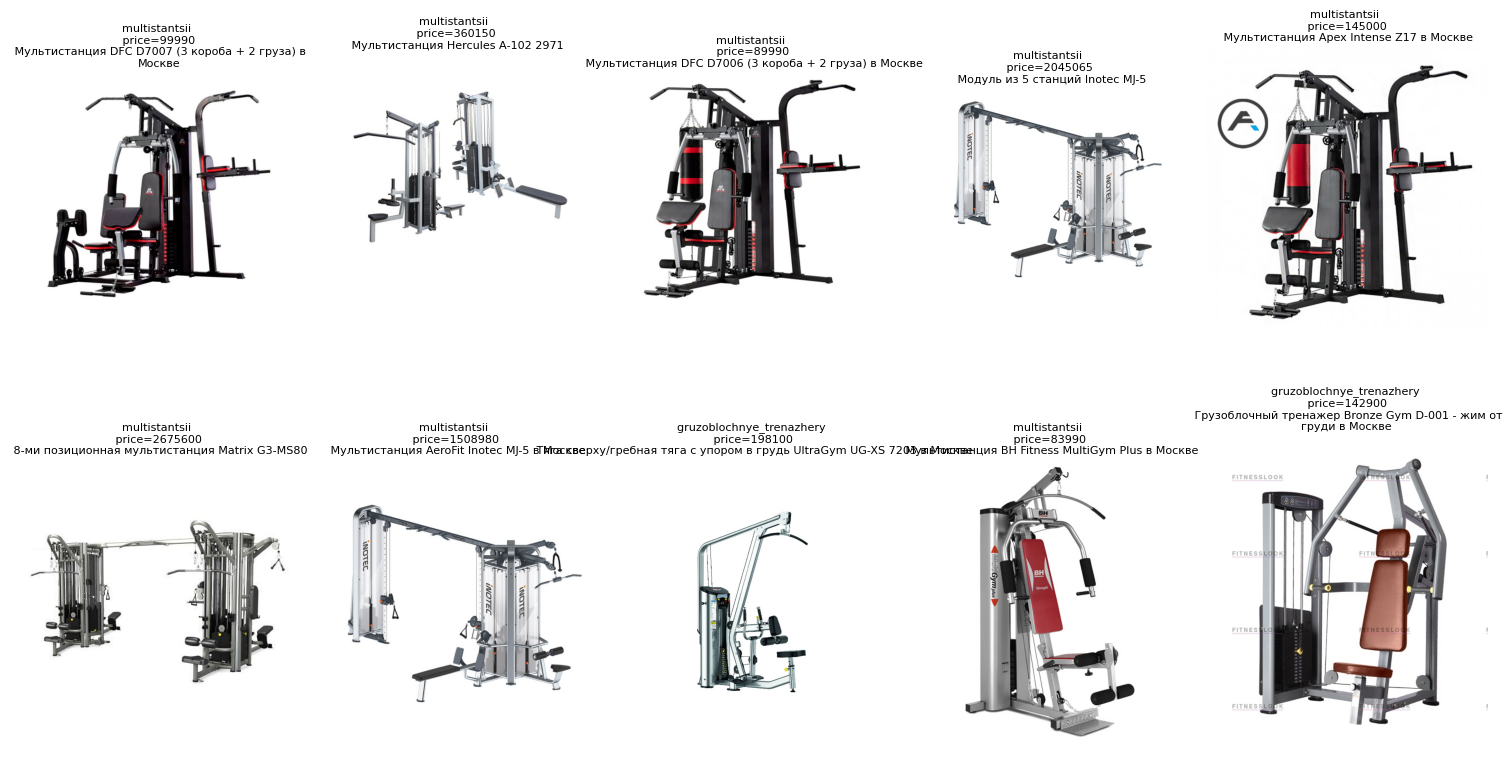

In [21]:
display_random_item(
    k=10,
    k_img=40,
    k_text=10,
    random_idx=621,
    method="ann_combined",
    company_data=company_data,
    company_emb=company_combined_emb_v2,
    database_emb=database_combined_emb_v2,
    comparable_data=comparable_data,
    forest=forest,
    text_model=None,
    tokenizer=None,
)

In [22]:
calc_ann_metric(
    10, forest, company_combined_emb_v2, company_data, comparable_data, combined=True
)
calc_ann_metric(
    5, forest, company_combined_emb_v2, company_data, comparable_data, combined=True
)

  0%|          | 0/984 [00:00<?, ?it/s]

multistantsii acc at 10: 0.6717
begovye_dorozhki acc at 10: 0.9907
ellipticheskie_trenazhery acc at 10: 0.9599
steppery acc at 10: 0.3
trenazhery_na_svobodnykh_vesakh acc at 10: 0.7027
grebnye_trenazhery acc at 10: 0.878
velotrenazhery acc at 10: 0.9736
Total acc at 10: 0.8501


  0%|          | 0/984 [00:00<?, ?it/s]

multistantsii acc at 5: 0.7083
begovye_dorozhki acc at 5: 0.9935
ellipticheskie_trenazhery acc at 5: 0.9743
steppery acc at 5: 0.3891
trenazhery_na_svobodnykh_vesakh acc at 5: 0.766
grebnye_trenazhery acc at 5: 0.926
velotrenazhery acc at 5: 0.9862
Total acc at 5: 0.8793
